# **High Value Customer Identification - Notebook A** 

Context
Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

Content
"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

**Tópicos neste notebook:**

1 - Data Description

2 - Feature Engineering

3 - Filtragem de Variáveis

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de negócio: selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Dez 2010 to Dez 2011)

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.

2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [38]:
import pandas as pd
import numpy as np
import math
import re
from IPython.display            import Image, display

import inflection
from unidecode                  import unidecode

import seaborn as sns
from matplotlib                 import pyplot as plt 
from plotly                     import express as px

from sklearn                    import cluster as c
from sklearn                    import metrics as m 
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Function

In [2]:
# Função para separar letras e números (filtrando dataset - produtos comprados (b) e cancelados(c))
def separar_letras_e_numeros(codigo):
    padrao = re.match(r'([A-Za-z]*)(\d*)', codigo)
    
    if padrao:
        letras = padrao.group(1)
        numeros = padrao.group(2)
        return letras, numeros
    else:
        return None, None

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Função para encontrar a média em dias, entre as últimas 3 compras do cliente
def calculo_rca_media_3(dates_list, max_date):

    # Colocando lista em ordem descrescente 
    sorted_dt_list = sorted(dates_list, reverse=True)
    
    # Encontrado o intervalo de tempo entre compras, em dias
    if len(dates_list) == 1:
        c1 = (max_date - sorted_dt_list[0]).days
        return c1
    
    if len(dates_list) == 2:
        c1 = (max_date - sorted_dt_list[0]).days
        c2 = (sorted_dt_list[0] - sorted_dt_list[1]).days
        return (c1+c2) / 2

    if len(dates_list) >= 3:
        c1 = (max_date - sorted_dt_list[0]).days
        c2 = (sorted_dt_list[0] - sorted_dt_list[1]).days
        c3 = (sorted_dt_list[1] - sorted_dt_list[2]).days
        return (c1+c2+c3) / 3

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Função para encontrar a média, em dias, entre a diferença (diff) de todas as datas de compras do cliente
def calculo_rca_media_total(dates_list, max_date):

    # Colocando as datas em ordem decrescente
    sorted_dt_list = sorted(dates_list, reverse=True)

    # Inserindo a última data do dataset em primeiro lugar da lista ordenada
    sorted_dt_list.insert(0, max_date)

    # Calculando a diferença entre cada data
    date_diff_list = [(sorted_dt_list[i] - sorted_dt_list[i - 1]).days for i in range(1, len(sorted_dt_list))]
    
    # Calculando a média de todos os intervalos
    media_rca_total = abs( sum(date_diff_list) / len(date_diff_list) )

    return media_rca_total



# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

# Configurações Gerais
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 0.2 Loading data

In [3]:
# Dataset treino
df_raw = pd.read_csv('../datasets/raw_datasets/data.csv', low_memory = False, encoding='ISO-8859-1')

# Removendo coluna vazia, devido ao csv ter vírgulas no final de cada linha
df_raw = df_raw.drop(['Unnamed: 8'], axis=1)

# **1.0 Data Description**

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.1 Rename Columns

In [6]:
# Renomeando as colunas usando a função underscore do inflection
df1.columns = [inflection.underscore(col) for col in df1.columns]
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Data Dimension

In [7]:
# Printando linhas/colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
'''
Existem 3 opções para tratar os NAs

1- Descartar linhas com valores ausentes (NA):
    Vantagem: rápido e fácil.
    Desvantagem (significativa): Pode levar à perda de informações importantes e prejudicar a performance do modelo se o conjunto de dados for pequeno.

2- Utilizar algoritmos de Machine Learning:
    Existem métodos para preencher valores ausentes (NA) que se baseiam no comportamento das colunas.
    Podemos utilizar métodos estatísticos como a média ou mediana, ou algorimos de Machine Learning para prever valores ausentes.
    Essa técnica é útil quando não se tem informações de negócio.

3- Entender a lógica de negócio:
    Compreendendo a lógica de negócio, é possível identificar o motivo dos valores ausentes e estabelecer regras para preenchê-los.  

Utilizarei a opção 3 para preencher os valores faltantes (NA) no próximo tópico.
'''

df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [10]:
# Preenchendo os NaN com lógica de negócio

# description
df1['description'] = df1['description'].fillna('no_description')

# customer_id
df1 = df1.dropna(subset=['customer_id'])

# Verificação da remoção dos NaN
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.6 Change Types

In [12]:
# Verificando os tipos de dados novamente após as alterações feitas no tópico 1.5, por boa prática.  
df1.dtypes

# Covertendo
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1.dtypes

C:\Users\andre\AppData\Local\Temp\ipykernel_5372\946814893.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])


invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

O conjunto de dados inclui as seguintes informações:

| Coluna                     | Descrição                                           |
|----------------------------|-----------------------------------------------------|
| Invoice Number             | Identificador único de cada transação.              |
| Stock Code Product         | Código do item.                                    |
| Description Product        | Nome do item.                                      |
| Quantity                   | A quantidade de cada item comprado por transação.  |
| Invoice Date               | O dia em que a transação ocorreu.                   |
| Unit Price                 | Preço do produto por unidade.                      |
| Customer ID                | Identificador único do cliente.                     |
| Country                    | O nome do país onde o cliente reside.               |
| invoice_date_formatted     | Data formatada (dia/mês/ano).                      |
| month                      | Número do mês.                                     |


## 1.7 Minority Changes (map data)

In [13]:
df1 = df1.drop_duplicates()

## 1.8 Descritive Statistics

In [14]:
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
quantity,401603.00,12.18,-80995.00,2.00,5.00,12.00,80995.00,250.28
invoice_date,401603,2017-07-07 22:53:53.288595712,2016-11-29 00:00:00,2017-04-04 00:00:00,2017-07-27 00:00:00,2017-10-18 00:00:00,2017-12-07 00:00:00,NaN
unit_price,401603.00,3.47,0.00,1.25,1.95,3.75,38970.00,69.76
customer_id,401603.00,15281.16,12346.00,13939.00,15145.00,16784.00,18287.00,1714.01


In [15]:
df1[df1['quantity'] == 80995]
df1[df1['quantity'] == -80995]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446,United Kingdom


# **2.0 Feature Engineering**

In [16]:
df2 = df1.copy()

## 2.1 Faturamento

In [17]:
# Faturamento por linha 
df2['faturamento'] = df2['quantity'] * df2['unit_price']

## 2.2 Separando dataset - Comprados(b) Cancelados(c)

In [18]:
# Aplicar a função a cada valor na coluna 'codigo'
df2[['invoice_letter', 'invoice_number']] = df2['invoice_no'].apply(lambda x: pd.Series(separar_letras_e_numeros(x)))

# Verificando se todos os valores da coluna quantidade são negativos.
df2[(df2['invoice_letter'] == 'C') & (df2['quantity'] > 0)].shape[0]

# Filtrando dataset
# Produtos cancelados 
df2c = df2[df2['invoice_letter'] == 'C']

# Produtos comprados 
df2b = df2[df2['invoice_letter'] != 'C']

# Verificando % de cancelados
prct_cancel = round(df2c.shape[0] / df2b.shape[0], 2) * 100
print(f'Os cancelamentos representam {prct_cancel}% do total de vendas')

Os cancelamentos representam 2.0% do total de vendas


In [19]:
# SOBRE TER COMPRADOS NA ANÁLISE MAS FORAM CANCELADOS

# df2b.shape[0]
# df2c.shape[0]
# 392731 - 8872 = 383859

# df2.shape[0] - 8872 - 8872 = 383859

# aaas = df2b[~df2b['invoice_no'].isin(df2c['invoice_number'])]
# aaas.shape[0]
# 392731

# Pelo visto o numero do chamado de compra e de cancelamento não são os mesmos numeros. então essa lógica não da certo.

## 2.3 Ticket médio, Valor total das compras, Total de transações (Todos por cliente)

In [20]:
# Soma de compras por cliente total de transações por cliente
fatur_cliente = df2b.groupby('customer_id').agg({ 'faturamento': 'sum', 'invoice_no':'nunique'}).reset_index()
# nunique aqui, pois os invoice_no se repetem devido cada linha do dataset ser um produto, ou seja, ele pode ter feito uma compra mas com vários produtos
# então aparecerá vários invoice_no repetidos.

# Renomeando colunas
fatur_cliente.columns = ['customer_id', 'total_valor', 'total_transacoes']

# Encontrando ticket médio
fatur_cliente['ticket_medio'] = fatur_cliente['total_valor'] / fatur_cliente['total_transacoes']
fatur_cliente

,customer_id,total_valor,total_transacoes,ticket_medio
0,12346,77183.60,1,77183.60
1,12347,4310.00,7,615.71
2,12348,1797.24,4,449.31
3,12349,1757.55,1,1757.55
4,12350,334.40,1,334.40
...,...,...,...,...
4334,18280,180.60,1,180.60
4335,18281,80.82,1,80.82
4336,18282,178.05,2,89.03
4337,18283,2045.53,16,127.85


## 2.4 Recencias

RECÊNCIA em dias, da última compra:

In [21]:
# RECÊNCIA em dias, da última compra:

# Data da última compra de cada cliente
rca_ultima_compra = df2b.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
# Renomeando colunas
rca_ultima_compra.rename(columns={'invoice_date': 'ultima_compra'}, inplace=True)

# Data maxima do dataset df2b inteiro
rca_ultima_compra['data_max'] = df2b['invoice_date'].max()
# Encontrando em dias, a diferença do ultimo dia de compra do cliente com a data max do dataset
rca_ultima_compra['recencia_ultima_compra'] = (rca_ultima_compra['data_max'] - rca_ultima_compra['ultima_compra']).dt.days
rca_ultima_compra

,customer_id,ultima_compra,data_max,recencia_ultima_compra
0,12346,2017-01-16,2017-12-07,325
1,12347,2017-12-05,2017-12-07,2
2,12348,2017-09-23,2017-12-07,75
3,12349,2017-11-19,2017-12-07,18
4,12350,2017-01-31,2017-12-07,310
...,...,...,...,...
4334,18280,2017-03-05,2017-12-07,277
4335,18281,2017-06-10,2017-12-07,180
4336,18282,2017-11-30,2017-12-07,7
4337,18283,2017-12-04,2017-12-07,3


RECÊNCIA média, em dias, das 3 últimas compras:

In [22]:
# RECÊNCIA média, em dias, das 3 últimas compras:

# Agrupando todos os chamados de cada cliente e utilizando o set para pegar apenas uma data unica, estava
# repetindo as datas, pois cada linha do dataset é um produto, se o cliente comprou mais de um produto no 
# mesmo dia resultava em várias datas iguais na coluna invoice_date com código de transação invoice_no repetido
rca_media_3 = df2b.groupby('customer_id')['invoice_date'].agg(lambda x: list(set(x))).reset_index()
rca_media_3.columns = ['customer_id', 'unique_invoice_dates']
rca_media_3

# Data maxima do dataset df2b inteiro
max_date = df2b['invoice_date'].max()
# Encontrando em dias, a diferença dos 3 últimos dias de compra do cliente com a data max do dataset
rca_media_3['recencia_media_3'] = rca_media_3['unique_invoice_dates'].apply(calculo_rca_media_3, args=(max_date,))
rca_media_3

,customer_id,unique_invoice_dates,recencia_media_3
0,12346,[2017-01-16 00:00:00],325.00
1,12347,"[2016-12-05 00:00:00, 2017-06-07 00:00:00, 201...",43.00
2,12348,"[2017-04-03 00:00:00, 2017-01-23 00:00:00, 201...",106.00
3,12349,[2017-11-19 00:00:00],18.00
4,12350,[2017-01-31 00:00:00],310.00
...,...,...,...
4334,18280,[2017-03-05 00:00:00],277.00
4335,18281,[2017-06-10 00:00:00],180.00
4336,18282,"[2017-08-03 00:00:00, 2017-11-30 00:00:00]",63.00
4337,18283,"[2017-06-12 00:00:00, 2017-11-21 00:00:00, 201...",5.33


RECÊNCIA média, em dias, de todas as compras:

In [23]:
# RECÊNCIA média, em dias, de todas as compras:

# Agrupando todos os chamados de cada cliente e utilizando o set para pegar apenas uma data unica, estava
# repetindo as datas, pois cada linha do dataset é um produto, se o cliente comprou mais de um produto no 
# mesmo dia resultava em várias datas iguais na coluna invoice_date com código de transação invoice_no repetido
rca_total_media = df2b.groupby('customer_id')['invoice_date'].agg(lambda x: list(set(x))).reset_index()

# Renomeando colunas
rca_total_media.columns = ['customer_id', 'unique_invoice_dates']

# Recencia Média em dias das 3 ultimas compras de cada cliente
max_date = df2b['invoice_date'].max()
rca_total_media['rencencia_media_total'] = rca_total_media['unique_invoice_dates'].apply(calculo_rca_media_total, args=(max_date,))
rca_total_media

,customer_id,unique_invoice_dates,rencencia_media_total
0,12346,[2017-01-16 00:00:00],325.00
1,12347,"[2016-12-05 00:00:00, 2017-06-07 00:00:00, 201...",52.43
2,12348,"[2017-04-03 00:00:00, 2017-01-23 00:00:00, 201...",89.50
3,12349,[2017-11-19 00:00:00],18.00
4,12350,[2017-01-31 00:00:00],310.00
...,...,...,...
4334,18280,[2017-03-05 00:00:00],277.00
4335,18281,[2017-06-10 00:00:00],180.00
4336,18282,"[2017-08-03 00:00:00, 2017-11-30 00:00:00]",63.00
4337,18283,"[2017-06-12 00:00:00, 2017-11-21 00:00:00, 201...",24.07


## 2.5 Cancelamentos por cliente

In [24]:
total_c = df2c.loc[:, ['customer_id', 'invoice_no']].groupby('customer_id').nunique().reset_index()
total_c.columns = ['customer_id', 'qnt_cancel']
total_c

,customer_id,qnt_cancel
0,12346,1
1,12352,3
2,12359,2
3,12362,3
4,12365,1
...,...,...
1584,18272,1
1585,18274,1
1586,18276,2
1587,18277,1


## 2.6 Merging datasets

In [25]:
# Dropando colunas desnecessárias para o merge
rca_ultima_compra = rca_ultima_compra.drop(['ultima_compra', 'data_max'], axis=1)
rca_media_3 = rca_media_3.drop(['unique_invoice_dates'], axis=1)
rca_total_media = rca_total_media.drop(['unique_invoice_dates'], axis=1)

# Merging 
df2_merged = pd.merge(fatur_cliente, rca_ultima_compra, on='customer_id', how='left')
df2_merged = pd.merge(df2_merged, rca_media_3, on='customer_id', how='left')
df2_merged = pd.merge(df2_merged, rca_total_media, on='customer_id', how='left')
df2_merged = pd.merge(df2_merged, total_c, on='customer_id', how='left').fillna(0)
df2_merged

,customer_id,total_valor,total_transacoes,ticket_medio,recencia_ultima_compra,recencia_media_3,rencencia_media_total,qnt_cancel
0,12346,77183.60,1,77183.60,325,325.00,325.00,1.00
1,12347,4310.00,7,615.71,2,43.00,52.43,0.00
2,12348,1797.24,4,449.31,75,106.00,89.50,0.00
3,12349,1757.55,1,1757.55,18,18.00,18.00,0.00
4,12350,334.40,1,334.40,310,310.00,310.00,0.00
...,...,...,...,...,...,...,...,...
4334,18280,180.60,1,180.60,277,277.00,277.00,0.00
4335,18281,80.82,1,80.82,180,180.00,180.00,0.00
4336,18282,178.05,2,89.03,7,63.00,63.00,1.00
4337,18283,2045.53,16,127.85,3,5.33,24.07,0.00


## 2.7 Ajustando features

In [26]:
# Colunas para inverter (ou elevadas a -1) para que, por exemplo, quanto mais cancelamentos, ter um peso menor do que maior.
colunas_inverter = ['recencia_ultima_compra', 'recencia_media_3', 'rencencia_media_total', 'qnt_cancel']

# Aplica a função lambda a todas as colunas especificadas
df2_merged[colunas_inverter] = df2_merged[colunas_inverter].applymap(lambda x: 1/x if x != 0 else 0)
df2_merged

C:\Users\andre\AppData\Local\Temp\ipykernel_5372\614776471.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2_merged[colunas_inverter] = df2_merged[colunas_inverter].applymap(lambda x: 1/x if x != 0 else 0)


,customer_id,total_valor,total_transacoes,ticket_medio,recencia_ultima_compra,recencia_media_3,rencencia_media_total,qnt_cancel
0,12346,77183.60,1,77183.60,0.00,0.00,0.00,1.00
1,12347,4310.00,7,615.71,0.50,0.02,0.02,0.00
2,12348,1797.24,4,449.31,0.01,0.01,0.01,0.00
3,12349,1757.55,1,1757.55,0.06,0.06,0.06,0.00
4,12350,334.40,1,334.40,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...
4334,18280,180.60,1,180.60,0.00,0.00,0.00,0.00
4335,18281,80.82,1,80.82,0.01,0.01,0.01,0.00
4336,18282,178.05,2,89.03,0.14,0.02,0.02,1.00
4337,18283,2045.53,16,127.85,0.33,0.19,0.04,0.00


# **3.0 Hyperparameter Fine-Tuning**

Em problemas de clusterização, o número de clusters precisa ser fornecido ao algoritmo previamente. Por isso primeiro fazemos o fine-tunning para encontrar o número ideal de clusters.

In [27]:
df3 = df2_merged.copy()

In [29]:
X = df3.drop(columns=['customer_id'])

In [30]:
clusters = np.arange(2, 10, 1)

## 3.1 Within-Cluster Sum of Square (WSS)

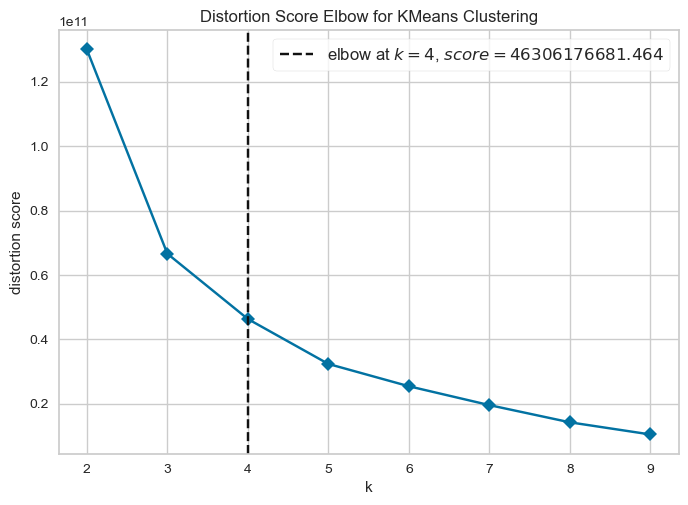

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 3.2 Silhouette Score

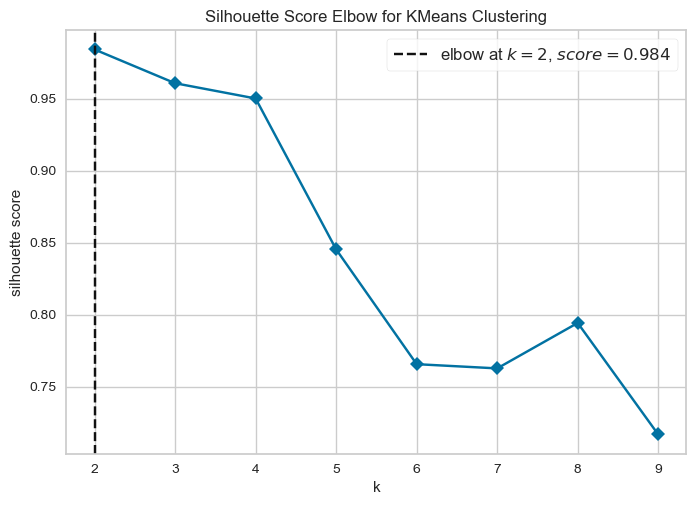

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [37]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

# Obteve melhor desempenho adicinando mais de uma feature de recência.

## 3.3 Visualização de Silhuetas (Gráfico de Facas)

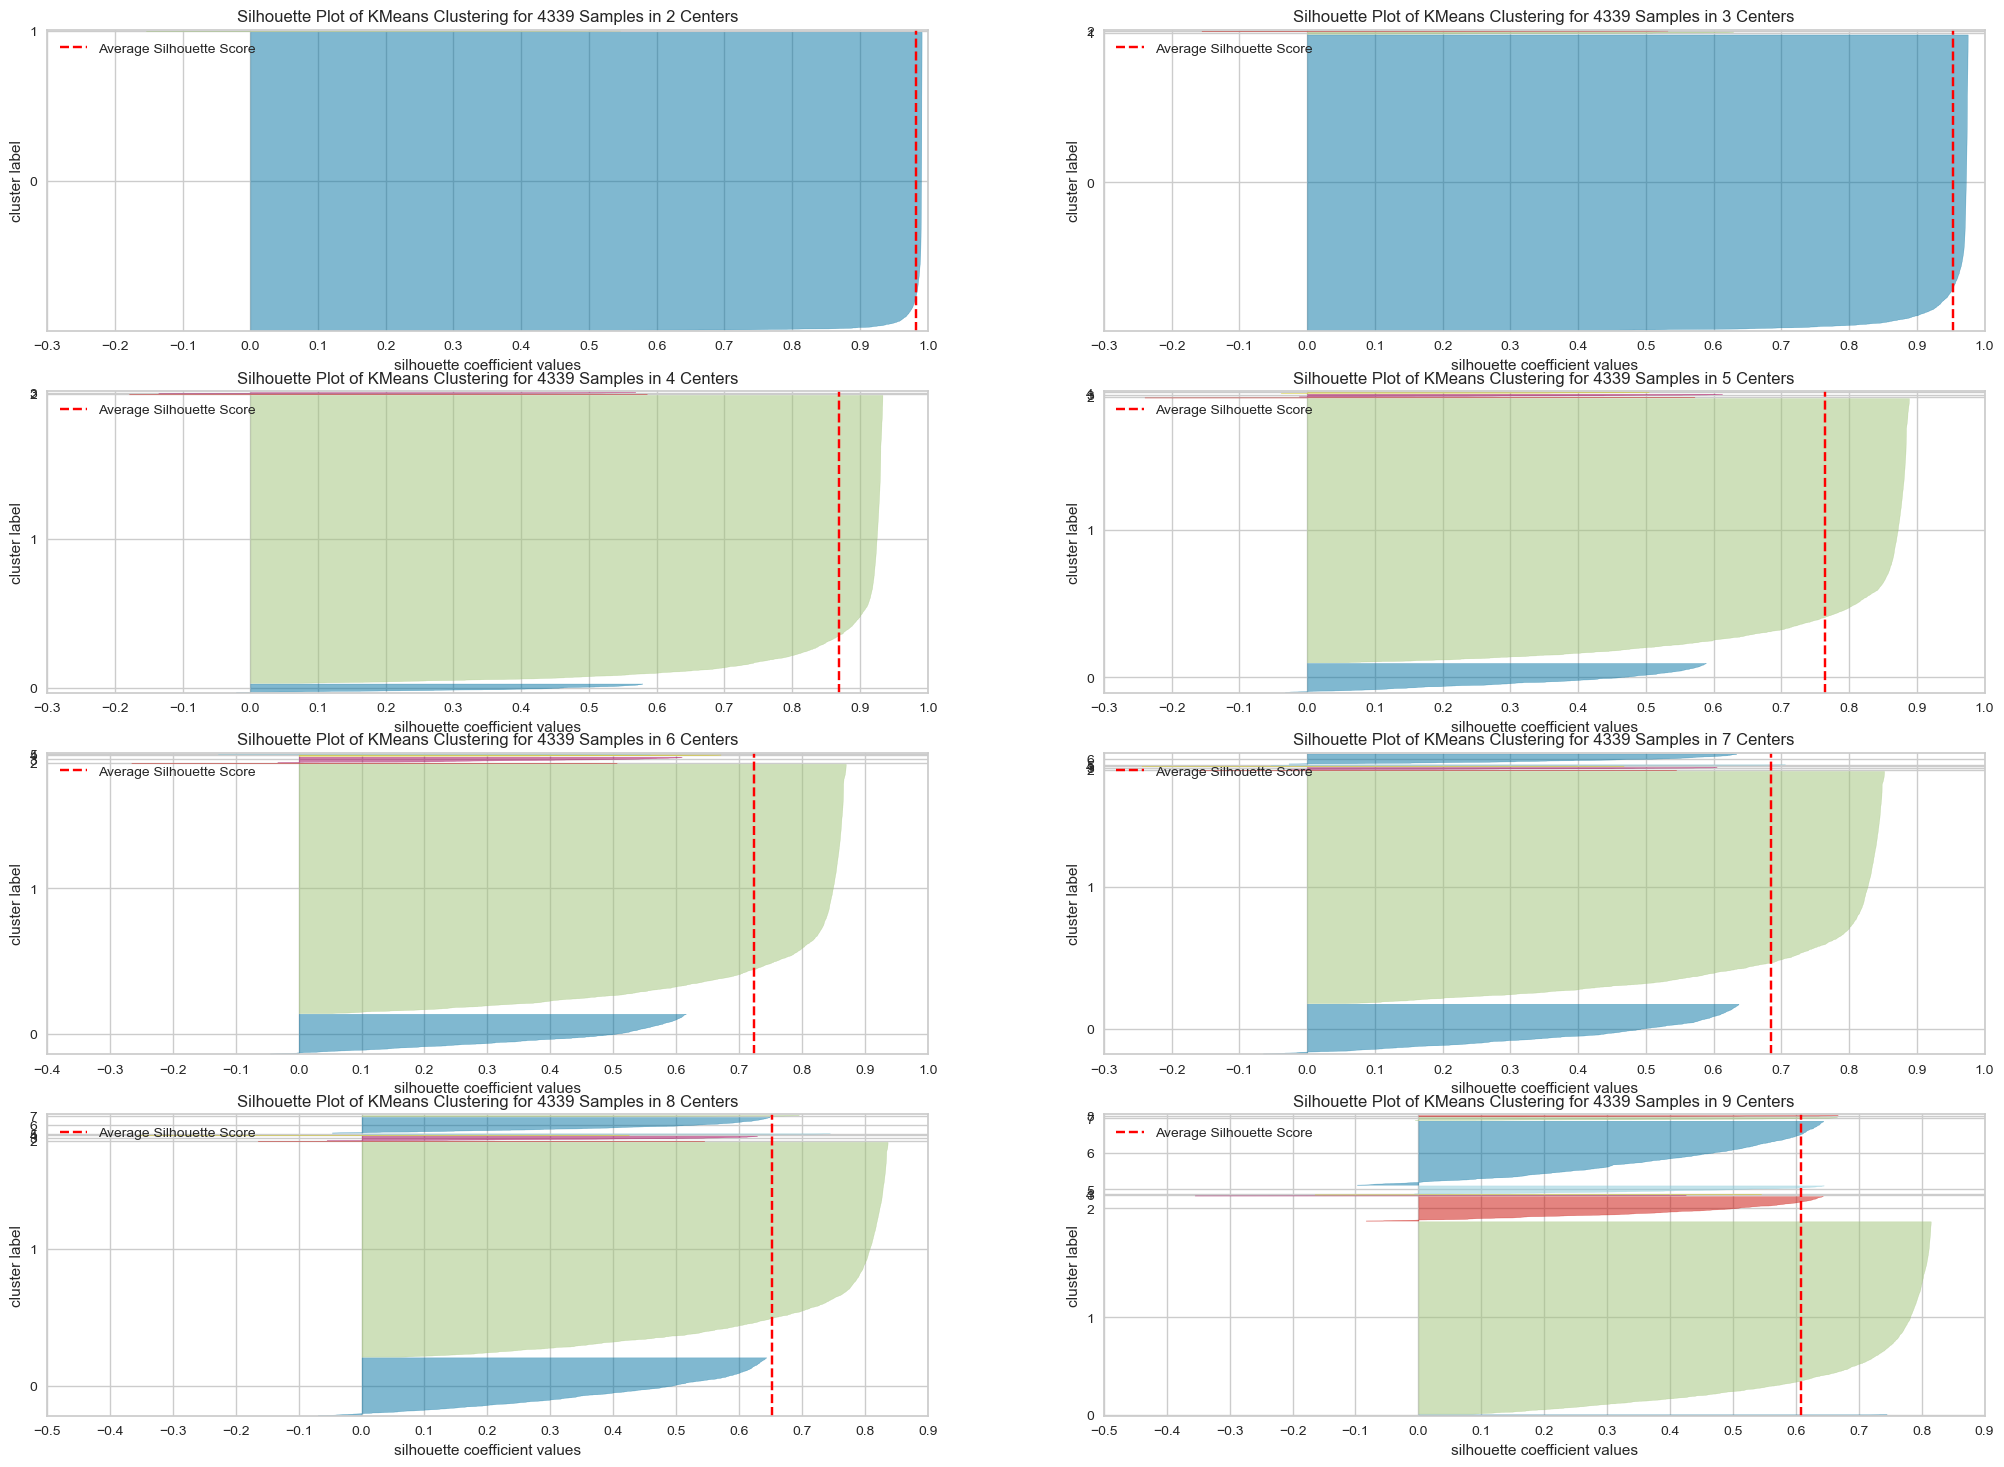

In [39]:
fig, ax = plt.subplots(4, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 4.0 Model Training

## 4.1 K-Means

In [40]:
# Model definition
k = 7 
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [46]:
# WSS (Within-cluster sum of square)
print(kmeans.inertia_)

# SS (Silhouette Score)
print(m.silhouette_score(X, labels, metric='euclidean'))

'''
kmeans.inertia_: Este é um atributo do objeto KMeans no sklearn que representa a soma dos quadrados intra-cluster, 
também conhecida como WSS (Within-cluster sum of square). O valor de inércia é uma métrica que indica a dispersão dos pontos dentro dos clusters. 
Quanto menor for o valor de inércia, mais compactos e bem definidos são os clusters. Este valor é uma medida útil para avaliar a qualidade do clustering, 
mas por si só não é suficiente para determinar o número ideal de clusters. Normalmente, o método do cotovelo (Elbow Method) é usado em conjunto com a 
inércia para encontrar o número ótimo de clusters.

m.silhouette_score(X, labels, metric='euclidean'): Aqui, você está calculando o escore de silhueta (Silhouette Score) usando a função silhouette_score
do módulo metrics do sklearn. O escore de silhueta é uma medida de quão semelhante um ponto de dados é ao seu próprio cluster (coesão) em comparação
com outros clusters (separação). Ele varia de -1 a 1, onde um valor mais próximo de 1 indica que o ponto está bem dentro do seu próprio cluster e
longe dos outros clusters, enquanto um valor mais próximo de -1 indica que o ponto está próximo ao limite de outro cluster. Um valor próximo de
0 indica que o ponto está próximo do limite entre dois clusters. Um escore de silhueta médio mais alto indica uma melhor separação entre os clusters.
O parâmetro metric='euclidean' especifica a métrica de distância a ser usada para calcular a silhueta (neste caso, a distância euclidiana).
'''

27047858239.566036
0.684934314008872


"\nkmeans.inertia_: Este é um atributo do objeto KMeans no sklearn que representa a soma dos quadrados intra-cluster, \ntambém conhecida como WSS (Within-cluster sum of square). O valor de inércia é uma métrica que indica a dispersão dos pontos dentro dos clusters. \nQuanto menor for o valor de inércia, mais compactos e bem definidos são os clusters. Este valor é uma medida útil para avaliar a qualidade do clustering, \nmas por si só não é suficiente para determinar o número ideal de clusters. Normalmente, o método do cotovelo (Elbow Method) é usado em conjunto com a \ninércia para encontrar o número ótimo de clusters.\n\nm.silhouette_score(X, labels, metric='euclidean'): Aqui, você está calculando o escore de silhueta (Silhouette Score) usando a função silhouette_score\ndo módulo metrics do sklearn. O escore de silhueta é uma medida de quão semelhante um ponto de dados é ao seu próprio cluster (coesão) em comparação\ncom outros clusters (separação). Ele varia de -1 a 1, onde um valor 

# 5.0 Cluster Analyslis

## 5.1 Visualization Inspection

## 5.2 Cluster Profile

In [ ]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

In [ ]:
df_cluster.sort_values('gross_revenue', ascending=False)

# 6.0 Deploy